# Problema 2 - Guía 5

In [2]:
import numpy as np
from tqdm import tqdm
from loky import ProcessPoolExecutor
from itertools import repeat
import pickle

In [5]:
# Algoritmo para implementar la red
class WS_1D(object):
    """
    Implementa una red Watts-Strogatz sobre un anillo, añadiendo conexiones al azar con probabilidad p.
    La red se implementa como un diccionario que representa la lista de vecinos del grafo.
    Además se retorna un array de spines inicializados aleatoriamente de acuerdo a la semilla.
    """
    # Implementamos los nodos
    def __init__(self,p,seed,N=10**5):
        nodes = [i for i in range(N)]

        neighbors_list = {}

        # Vecinos para todos los nodos excepto el primero y el último
        for node in nodes[1:-1]:
            neighbors_list[node] = [node-1,node+1]
        # Fijamos condiciones periódicas
        neighbors_list[0] = [1,N-1]
        neighbors_list[N-1] = [N-2,0]
    
        # Ahora agregamos conexiones aleatorias con probabilidad p
        ## Inicializamos generador de números aleatorios
        random_state = np.random.RandomState(seed)
        for i in range(N):
            j = i
            while i == j: # Esto es para que no haya auto enlaces en la red
                j = random_state.randint(0,N)
            ### Agregamos j a la lista de vecinos de i y viceversa
            if random_state.random() < p:
                neighbors_list[i].append(j)
                neighbors_list[j].append(i)
        self.neighbors_list = neighbors_list
        # Inicializamos array de spines
        self.spins = random_state.choice(a=[1,-1],size=N)

# Ahora implementamos la dinámica de Ising en otra clase
class IsingExp(object):
    """
    Clase para realizar simulación Montecarlo del Modelo de Ising
    """
    def __init__(self,p,seed,N=10**5,T=10**6):
        self.p = p
        self.seed = seed
        self.N = N
        self.T = T
        self.network = WS_1D(p,seed)
        self.random_state = np.random.RandomState(self.seed)
        self.flips = 0 # Esto es sólo para debug, lleva registro de los flips aceptados
    # Funciones para la simulación
    def __deltaE(self,i):
        """
        Calcula el cambio de energía al flipear el spin del sitio i
        """
        spin_i = self.network.spins[i]
        neighbors_i = self.network.neighbors_list[i]
        ## Energía inicial
        E0 = - sum(spin_i * self.network.spins[j] for j in neighbors_i)
        ## Energía haciendo flip de spin_i
        E = - sum( (-spin_i) * self.network.spins[j] for j in neighbors_i)
        return E-E0
    def __MCstep(self):
        i = self.random_state.randint(0,self.N)
        deltaE = self.__deltaE(i)
        # ΔE <0 -> Aceptamos flip
        if deltaE < 0:
            self.network.spins[i] = - self.network.spins[i]
            self.flips += 1
        # ΔE = 0 se sortea
        elif deltaE == 0:
            if self.random_state.random() < 0.5:
                self.network.spins[i] = - self.network.spins[i]
                self.flips += 1
    def get_E(self):
        E = 0
        for i in range(self.N):
            spin_i = self.network.spins[i]
            neighbors_i = self.network.neighbors_list[i]
            E += -sum(spin_i * self.network.spins[j] for j in neighbors_i)
        return E/2
    def get_M(self):
        return self.network.spins.sum()
    def run(self):
        energy = []
        magnetization = []
        for t in tqdm(range(self.T)):
            self.__MCstep()
            if t%1000==0:
                energy.append(self.get_E())
                magnetization.append(self.get_M())
        return self.network.neighbors_list,self.network.spins,energy,magnetization

In [6]:
data = IsingExp(0.01,42).run()

100%|███████████████████████████████████████████████████████████████████████| 1000000/1000000 [02:04<00:00, 8009.24it/s]


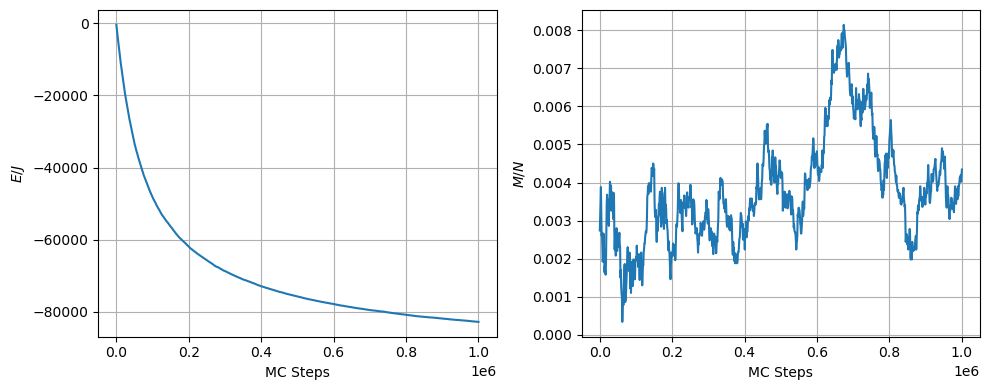

In [7]:
from matplotlib import pyplot as plt

steps = np.linspace(0,10**6,10**3)

fig, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].plot(steps,data[2])
axs[1].plot(steps,np.array(data[3])/10**5)

axs[0].set_ylabel('$E/J$')
axs[1].set_ylabel('$M/N$')

axs[0].set_xlabel('MC Steps')
axs[1].set_xlabel('MC Steps')

axs[0].grid()
axs[1].grid()

plt.tight_layout()

plt.savefig('IsingRun_EMSteps.jpg',dpi=300)

/home/bombi/miniconda3/envs/famaf/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  after removing the cwd from sys.path.


<Figure size 800x1000 with 0 Axes>

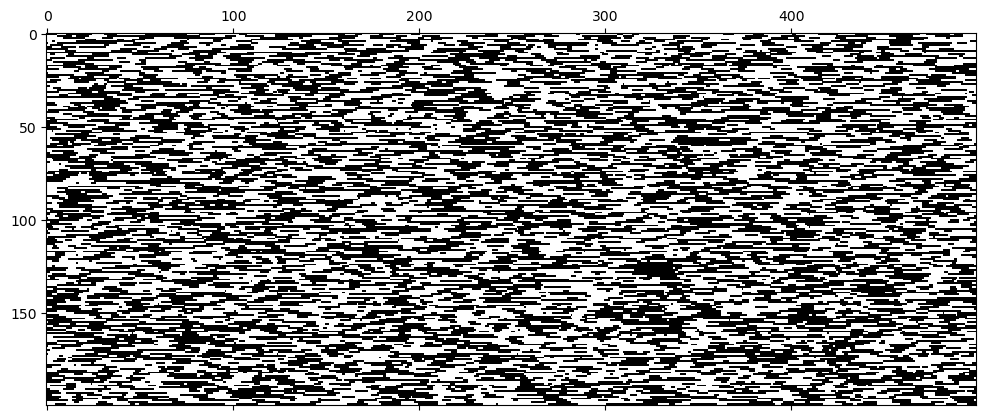

In [31]:
plt.figure(figsize=(8,10))
plt.matshow(data[1].reshape(200,500),cmap='gray')

plt.tight_layout()

plt.savefig('Domains_spins.jpg',dpi=300)

In [14]:
## Función main paralelizable
def main(p,seed):
    experiment = IsingExp(p,seed)
    return experiment.run()

In [15]:
# Vamos a hacer el experimento unas 256 veces
runs = 16
p = 0.01
with ProcessPoolExecutor() as ppe:
    results = list(tqdm(ppe.map(main,repeat(p,runs),range(runs)),total=runs))

with open('ising_p001_16runs','wb') as f:
    pickle.dump(results,f)
del(results) # Hay que hacer lugar en memoria para la siguiente simulación

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.66s/it]


In [16]:
runs = 16
p = 0.02
with ProcessPoolExecutor() as ppe:
    results = list(tqdm(ppe.map(main,repeat(p,runs),range(runs)),total=runs))
with open('ising_p002_16runs','wb') as f:
    pickle.dump(results,f)
del(results)

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.63s/it]


In [17]:
runs = 16
p = 0.04
with ProcessPoolExecutor() as ppe:
    results = list(tqdm(ppe.map(main,repeat(p,runs),range(runs)),total=runs))
with open('ising_p004_16runs','wb') as f:
    pickle.dump(results,f)
del(results)    

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.64s/it]


In [18]:
runs = 16
p = 0.06
with ProcessPoolExecutor() as ppe:
    results = list(tqdm(ppe.map(main,repeat(p,runs),range(runs)),total=runs))
with open('ising_p006_16runs','wb') as f:
    pickle.dump(results,f)
del(results)    

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.64s/it]


In [19]:
runs = 16
p = 0.10
with ProcessPoolExecutor() as ppe:
    results = list(tqdm(ppe.map(main,repeat(p,runs),range(runs)),total=runs))
with open('ising_p010_16runs','wb') as f:
    pickle.dump(results,f)
del(results)    

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.66s/it]
